In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
import shap

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
usage = pd.read_csv('takehome_user_engagement.csv')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
# Convert creation_time and last_session_creation_time into datetime objects
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit = 's')
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [6]:
users.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [7]:
print('There are {} inactive users, let\'s remove them.'.format(users.last_session_creation_time.isna().sum()))
users = users[~users.last_session_creation_time.isna()]
users.info()

There are 3177 inactive users, let's remove them.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   int64         
 9   invited_by_user_id          4776 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 7

In [8]:
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [9]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [10]:
# This matches number of active users in users table
len(usage.user_id.unique())

8823

In [11]:
users.duplicated().sum()

0

In [12]:
usage.duplicated().sum()

0

There are no duplicates found in either dataframe.

In [13]:
usage['time_stamp'] = pd.to_datetime(usage['time_stamp'])
usage['date'] = usage.time_stamp.dt.date

In [14]:
usage.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [15]:
#adopted user - 3 separate days within 7 day period
usage = usage.sort_values(by = ['user_id', 'time_stamp'])

from datetime import datetime, timedelta

def num_logins(df, days = 3, period = 7):
    df = df.drop_duplicates(subset = 'date')
    numDays = df['date'].diff(periods = days - 1)
    return any(numDays <= timedelta(period))

adoptedUsers = usage.groupby('user_id').apply(num_logins).to_frame()
adoptedUsers.columns = ['adopted_user']

In [16]:
print('There are {} adopted users out of {} active users.'.format(adoptedUsers['adopted_user'].sum(), len(users['object_id'].unique())))

There are 1656 adopted users out of 8823 active users.


In [17]:
joined = users.join(adoptedUsers, on = 'object_id')
joined.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


In [18]:
# Name and email will not be useful in predicting user adoption, let's drop these columns
joined = joined.drop(columns = ['name', 'email'])
joined

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False
...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,False
11996,11997,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,False
11997,11998,2014-04-27 12:45:16,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,False
11998,11999,2012-05-31 11:55:59,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,False


In [19]:
# create new variable duration (length of days between creation time and last session)
joined['duration'] = joined.last_session_creation_time - joined.creation_time
joined['duration'] = joined.duration.dt.days
joined = joined.drop(columns = ['last_session_creation_time', 'creation_time'])
joined.duration.value_counts()

0      3027
1      1617
2       822
3       405
4       195
       ... 
529       1
513       1
497       1
310       1
341       1
Name: duration, Length: 512, dtype: int64

In [20]:
creationSource = joined.groupby(['creation_source', 'adopted_user']).count()['object_id'].reset_index()
creationSource.columns = ['source', 'Adopted', 'count']
creationSource.head()

,source,Adopted,count
0,GUEST_INVITE,False,1219
1,GUEST_INVITE,True,369
2,ORG_INVITE,False,2614
3,ORG_INVITE,True,574
4,PERSONAL_PROJECTS,False,592


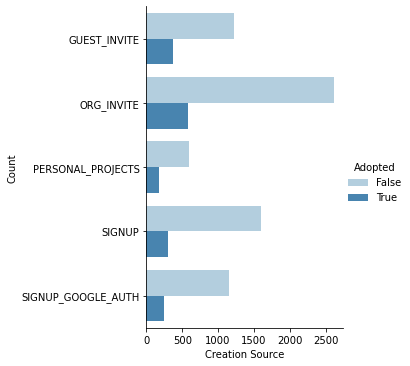

In [21]:
sns.catplot(data = creationSource, x = 'count', y = 'source', hue = 'Adopted', kind = 'bar', orient = 'h', palette = 'Blues')
plt.xlabel('Creation Source')
plt.ylabel('Count')
plt.show()

In [22]:
# dummy encode creation source
joined = joined.join(pd.get_dummies(joined['creation_source'])).drop(columns = 'creation_source')

In [23]:
mailingList = joined.groupby(['opted_in_to_mailing_list', 'adopted_user']).count()['object_id'].reset_index()
mailingList.columns = ['opted_in_to_mailing_list', 'Adopted', 'count']
mailingList.head()

,opted_in_to_mailing_list,Adopted,count
0,0,False,5370
1,0,True,1227
2,1,False,1797
3,1,True,429


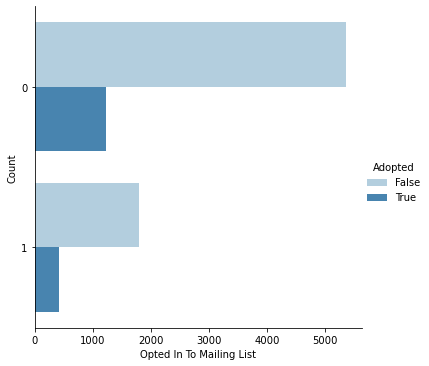

In [24]:
sns.catplot(data = mailingList, x = 'count', y = 'opted_in_to_mailing_list', hue = 'Adopted', kind = 'bar', orient = 'h', palette = 'Blues')
plt.xlabel('Opted In To Mailing List')
plt.ylabel('Count')
plt.show()

In [25]:
marketingDrip = joined.groupby(['enabled_for_marketing_drip', 'adopted_user']).count()['object_id'].reset_index()
marketingDrip.columns = ['enabled_for_marketing_drip', 'Adopted', 'count']
marketingDrip.head()

,enabled_for_marketing_drip,Adopted,count
0,0,False,6083
1,0,True,1399
2,1,False,1084
3,1,True,257


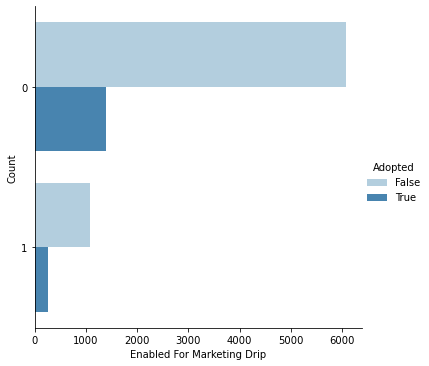

In [26]:
sns.catplot(data = marketingDrip, x = 'count', y = 'enabled_for_marketing_drip', hue = 'Adopted', kind = 'bar', orient = 'h', palette = 'Blues')
plt.xlabel('Enabled For Marketing Drip')
plt.ylabel('Count')
plt.show()

In [27]:
orgCounts = joined.org_id.value_counts(dropna = False).to_frame().reset_index()
orgCounts.columns = ['org_id', 'count']
orgCounts

,org_id,count
0,0,228
1,1,172
2,2,150
3,3,125
4,4,122
...,...,...
412,322,6
413,400,6
414,397,5
415,386,4


In [28]:
orgCounts[:20]

,org_id,count
0,0,228
1,1,172
2,2,150
3,3,125
4,4,122
5,6,102
6,9,91
7,7,88
8,5,87
9,10,68


In [29]:
# Let's keep the top 10 orgs and group the rest into others (999)
topOrgs = orgCounts.org_id[:10].to_list()
joined['org_id'] = np.where(joined.org_id.isin(topOrgs),joined.org_id, 999)
joined = joined.join(pd.get_dummies(joined.org_id, 'org_id'))
joined = joined.drop(columns = 'org_id')
joined

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted_user,duration,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,...,org_id_1,org_id_2,org_id_3,org_id_4,org_id_5,org_id_6,org_id_7,org_id_9,org_id_10,org_id_999
0,1,1,0,10803.0,False,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,0,316.0,True,136,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,0,0,1525.0,False,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0,0,5151.0,False,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,0,0,5240.0,False,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,0,0,8263.0,False,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
11996,11997,0,0,NaN,False,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11997,11998,1,1,8074.0,False,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11998,11999,0,0,NaN,False,2,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [30]:
joined.invited_by_user_id.value_counts(dropna = False)

NaN        4047
4612.0       10
2308.0        9
11770.0       9
1525.0        8
           ... 
3337.0        1
10797.0       1
5139.0        1
9819.0        1
10941.0       1
Name: invited_by_user_id, Length: 2230, dtype: int64

In [31]:
#create new variable invited (1: invited by user, 0: not invited by user)

joined['invited'] = np.where(joined.invited_by_user_id.isna(), 0, 1)
joined = joined.drop(columns = 'invited_by_user_id')
joined

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,duration,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,...,org_id_2,org_id_3,org_id_4,org_id_5,org_id_6,org_id_7,org_id_9,org_id_10,org_id_999,invited
0,1,1,0,False,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,2,0,0,True,136,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,False,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,0,0,False,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,0,False,5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,0,0,False,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
11996,11997,0,0,False,5,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
11997,11998,1,1,False,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
11998,11999,0,0,False,2,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [32]:
joined = joined.set_index('object_id')
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    8823 non-null   int64
 1   enabled_for_marketing_drip  8823 non-null   int64
 2   adopted_user                8823 non-null   bool 
 3   duration                    8823 non-null   int64
 4   GUEST_INVITE                8823 non-null   uint8
 5   ORG_INVITE                  8823 non-null   uint8
 6   PERSONAL_PROJECTS           8823 non-null   uint8
 7   SIGNUP                      8823 non-null   uint8
 8   SIGNUP_GOOGLE_AUTH          8823 non-null   uint8
 9   org_id_0                    8823 non-null   uint8
 10  org_id_1                    8823 non-null   uint8
 11  org_id_2                    8823 non-null   uint8
 12  org_id_3                    8823 non-null   uint8
 13  org_id_4                    8823 non-null   uint8
 14  org_id_

<AxesSubplot:>

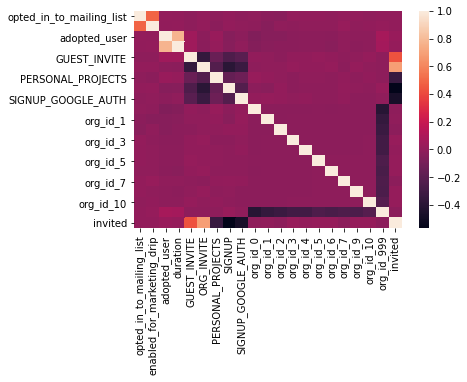

In [33]:
corr = joined.corr()
sns.heatmap(corr)

In [34]:
corr.adopted_user.sort_values(ascending = False)

adopted_user                  1.000000
duration                      0.777844
org_id_999                    0.079049
GUEST_INVITE                  0.053605
PERSONAL_PROJECTS             0.029523
invited                       0.027138
opted_in_to_mailing_list      0.007485
enabled_for_marketing_drip    0.004290
org_id_7                     -0.001510
org_id_9                     -0.008849
org_id_10                    -0.009171
org_id_5                     -0.012718
org_id_4                     -0.014662
ORG_INVITE                   -0.014719
SIGNUP_GOOGLE_AUTH           -0.016719
org_id_6                     -0.022116
org_id_3                     -0.023239
org_id_2                     -0.029535
org_id_1                     -0.034186
SIGNUP                       -0.038315
org_id_0                     -0.056336
Name: adopted_user, dtype: float64

# Model Building

In [35]:
X = joined.drop(columns = 'adopted_user')
y = joined['adopted_user'].astype(int)

In [36]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,duration,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,org_id_0,org_id_1,org_id_2,org_id_3,org_id_4,org_id_5,org_id_6,org_id_7,org_id_9,org_id_10,org_id_999,invited
object_id,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,136,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5,0,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [37]:
y.head()

object_id
1    0
2    1
3    0
4    0
5    0
Name: adopted_user, dtype: int64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

### Random Forest

In [39]:
# use random forest model with balanced class weights to correct for imbalance in the data
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200],
          'max_features': ['auto', 'sqrt', 'log2'], 
          'max_depth' :  np.arange(4,50), 
          'criterion' :['gini', 'entropy'],
          'min_samples_split' : [2, 3, 4]}
model = RandomizedSearchCV(clf, params)
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 100, 'min_samples_split': 4, 'max_features': 'sqrt', 'max_depth': 26, 'criterion': 'gini'}
Best average precision was 0.9506152797977018


In [40]:
# Fit best model
best_params = {'n_estimators': 200, 'min_samples_split': 3, 'max_features': 'log2', 'max_depth': 13, 'criterion': 'entropy'}

bestModel = RandomForestClassifier(random_state=42, class_weight='balanced', **best_params)
bestModel.fit(X_train, y_train)
y_pred = bestModel.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Classsification Report: ",'\n', classification_report(y_test, y_pred))

print("Confusion Matrix: ",'\n', cm)

Classsification Report:  
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      2164
           1       0.81      0.93      0.87       483

    accuracy                           0.95      2647
   macro avg       0.90      0.94      0.92      2647
weighted avg       0.95      0.95      0.95      2647

Confusion Matrix:  
 [[2062  102]
 [  35  448]]


In [41]:
# take a look at feature importance
imp = pd.DataFrame({'Predictors':X.columns, 'feature_importance': bestModel.feature_importances_})
imp = imp.sort_values(by = 'feature_importance', ascending=False)
imp

,Predictors,feature_importance
2,duration,0.966073
0,opted_in_to_mailing_list,0.004918
18,org_id_999,0.004141
1,enabled_for_marketing_drip,0.003943
3,GUEST_INVITE,0.002733
8,org_id_0,0.002497
6,SIGNUP,0.002004
7,SIGNUP_GOOGLE_AUTH,0.001565
9,org_id_1,0.001518
4,ORG_INVITE,0.001422


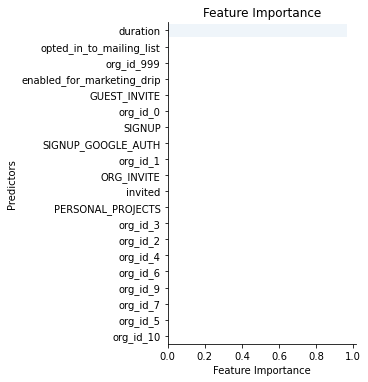

In [42]:
sns.catplot(data=imp, x = 'feature_importance', y = 'Predictors', kind = 'bar', orient = 'h', palette = 'Blues')
plt.xlabel('Feature Importance')
plt.ylabel('Predictors')
plt.title('Feature Importance')
plt.show()

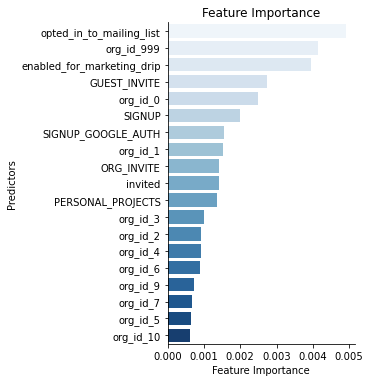

In [43]:
sns.catplot(data=imp[1:], x = 'feature_importance', y = 'Predictors', kind = 'bar', orient = 'h', palette = 'Blues')
plt.xlabel('Feature Importance')
plt.ylabel('Predictors')
plt.title('Feature Importance')
plt.show()

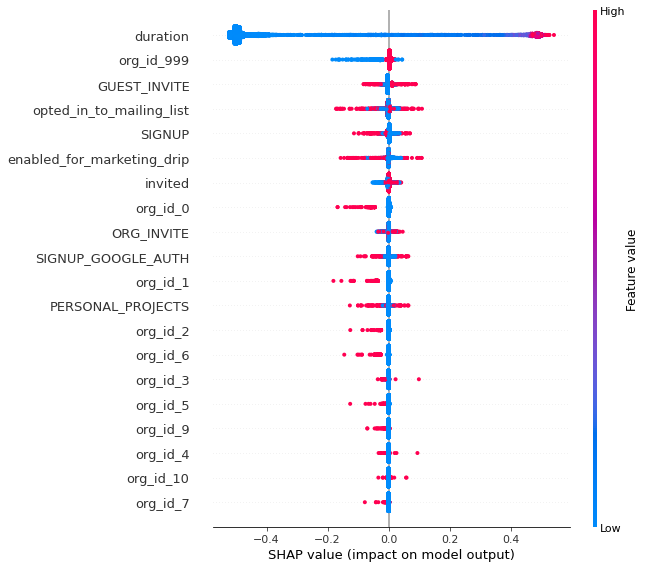

In [44]:
explainer = shap.TreeExplainer(bestModel)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train)
